# **1.2 Create Patches** 

LOCAL   
data on local/extern SSD

## 1. Preparations
### 1.1 Import required packages

In [3]:
# import rasterio
try:
    import rasterio
except:
    %pip install rasterio
    import rasterio

import rasterio.features
import rasterio.warp
from rasterio.windows import Window
from rasterio.features import geometry_mask
from rasterio.features import rasterize

In [4]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import json  # for saving patch metadata in JSON format

### 1.2 Set directories and file paths

In [ ]:
# input directories
# raster data as GeoTIFFs
gtif_dir = r"D:\Drohne\1_OHB\1_OHB_Normalbetrieb\3_OHB_Juli_2024\Outputs\RGB\GeoTIFF"
# labels as shapefile
shp_dir = r"C:\Users\simon\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\shapefiles"

# output directories 
# for raw patches
# as NumpyArrays
output_raw_patches_dir = r"D:\MoSE\preprocessing\patches_raw"

# for JSON class codes
output_json_dir = r"D:\MoSE\preprocessing\codes"

# for masks
output_raw_masks_dir = r"D:\MoSE\preprocessing\masks_raw"

## 2. Create Patches
### 2.1 Set Hyperparameters

In [200]:
##############################################################################################
# exact paths to files
# raster data
gtif_name = "A07"
gtif_path = gtif_dir + r"\OHB_Abschnitt_07_tight.tif"
# class labels
shp_path = shp_dir + r"\GSK_24_WGS84_adjusted.shp"
##############################################################################################

In [201]:
# parameters for patches
PATCH_SIZE = 512 # 512x512 pixel per patch
STRIDE = 256 # 256 pixel overlap between patches

### 2.2 Label preparations and Class Coding

In [202]:
labels = gpd.read_file(shp_path)
labels["Elementtyp"].unique()

array(['Einzelstein', 'Wurzelstock', 'Steinverbauung', 'Totholz',
       'Steinriegel', 'Schotterbank', 'Schlamm_Sandinsel',
       'Sand_Schlammbank', 'Schotterinsel', None], dtype=object)

In [203]:
# Remove labels without class assignment
labels_filtered = labels[labels["Elementtyp"].notnull()]

# Exclude classes with not enough or too small labels
exclude_classes = ['Einzelstein', 'Steinverbauung', 'Steinriegel', 'Schlamm_Sandinsel', 'Schotterinsel']
labels_filtered = labels_filtered[~labels_filtered["Elementtyp"].isin(exclude_classes)]

print("4 classes (without background class): ", labels_filtered["Elementtyp"].unique())

4 classes (without background class):  ['Wurzelstock' 'Totholz' 'Schotterbank' 'Sand_Schlammbank']


Class coding

In [204]:
label_codes = { # assign a unique pixel value to each class (element type)
    "Totholz": 1,
    "Wurzelstock": 2,
    "Sand_Schlammbank": 3,
    "Schotterbank": 4
}

In [205]:
label_codes.items()

dict_items([('Totholz', 1), ('Wurzelstock', 2), ('Sand_Schlammbank', 3), ('Schotterbank', 4)])

In [206]:
# dictionary
label_codes["Totholz"]

1

In [207]:
# reversed dictionary
reversed_label_codes = {v: k for k, v in label_codes.items()} # v = value, k = key
reversed_label_codes[1]

'Totholz'

In [208]:
num_classes = len(label_codes)
num_classes

4

In [209]:
label_codes_path = os.path.join(output_json_dir, "label_codes.json")
with open(label_codes_path, "w") as json_file:
    json.dump(label_codes, json_file, indent=4)

### 2.3 Create the patch loop

In [ ]:
#######################################################
# 1. Load the GeoTIFF (orthophoto)
with rasterio.open(gtif_path) as src:
    # nparr_data = src.read() # reads raster data of the GeoTIFF as NumPy-Array
    gtif_width, gtif_height = src.width, src.height
    gtif_transform = src.transform  # transformation matrix (whole image)
    gtif_crs = src.crs  # coordinate system
    gtif_meta = src.meta.copy() # original metadata like coordinate system, resolution, datatype
    gtif_bounds = src.bounds
    #######################################################

    # 2. Transform labels to crs of the orthophoto
    labels_crs = labels_filtered.to_crs(gtif_crs)

    #######################################################
    # 3. LOOP for patches
    #######################################################

    # set patch-id to zero
    patch_id = 0 # unique counter

    # Loop over the image in steps of STRIDE (overlapping patches if STRIDE < PATCH_SIZE)
    for y in range(0, gtif_height, STRIDE): # vertical movement y (start point: 0, end point: height, steps: STRIDE)
        for x in range(0, gtif_width, STRIDE): # horizontal movement x (start point: 0, end point: width, steps: STRIDE)
            
            # 3.1 Define window (patch)
            window = Window(x, y, PATCH_SIZE, PATCH_SIZE) 
            # defines a patch/window with origin (x, y) and a size of PATCH_SIZExPATCH_SIZE 

            # 3.2 Calculate the transformation matrix for this patch
            patch_transform = src.window_transform(window) 
            # this transformation matrix describes how the pixel coordinates of this window can be converted into 
            # the world coordinates of the image (geocoordinates)

            # 3.3 Extract raster data for the patch
            patch_data = src.read(window=window, indexes=[1, 2, 3]) # read only the first three bands (ignore the fourth band)
            # patch_data should be an array with shape [bands, PATCH_SIZE, PATCH_SIZE]
            
            # 3.4 Skip incomplete patches
            # if the calculated patch is partially outside the image boundaries (patch is smaller than PATCH_SIZE),
            # skip the patch to avoid errors
            if patch_data.shape[1] < PATCH_SIZE or patch_data.shape[2] < PATCH_SIZE:
                continue

            # 3.5 Check for "NoData" pixels in bands 0-2 (value = 0)
            nodata_value = 0  # Define the NoData value
            nodata_pixels = (patch_data == nodata_value).sum()  # Count NoData pixels across all bands
            total_pixels = PATCH_SIZE * PATCH_SIZE * patch_data.shape[0]  # Total pixels in the patch (3 bands)
            nodata_ratio = nodata_pixels / total_pixels # calculate the nodata-ratio
            # Skip patch if more than 50% of the pixels are NoData
            if nodata_ratio > 0.5:
                continue

            #######################################################
            # 4. Create masks for the labels
            #######################################################

            # 4.1 Calculate geographical coordinates (boundaries) of current patch 
            patch_bounds = rasterio.windows.bounds(window, gtif_transform) # with orthophoto transformation matrix 
            
            # 4.2 Filters label polygons which are inside the patch
            patch_labels = labels_crs.cx[ # labels_crs.cx (pandas) > filters geometries by coordinates
                patch_bounds[0]:patch_bounds[2],  # min_x:max_x
                patch_bounds[1]:patch_bounds[3],  # min_y:max_y
            ]
            

            
            # 4.3 Create binary masks with as many layers as classes
            # set mask to None
            mask = None

            if not patch_labels.empty: # if there are any labels in this patch 
                mask = np.zeros((num_classes, PATCH_SIZE, PATCH_SIZE), dtype=np.uint8) # initialize empty mask with 4 layers for the 4 classes
                
                # print("Labels in the patch:\n", patch_labels)
                # for every (row in) existing labels in this patch
                for _, row in patch_labels.iterrows():

                    class_name = row["Elementtyp"] # wich class has this label?
                    # print(class_name)

                    geom = row["geometry"] # wich geometry has this label?
                    # print(geom)
                              
                    class_idx = label_codes[class_name] - 1  # so in **wich layer/position in the mask** depending on the class
                                                             # should we write the geometry of this label
                    # print("layer", class_idx, "of the mask")

        
                    # fill mask with code values
                    mask[class_idx] = rasterize( # rasterize in layer "?" of the mask
                        [(geom, 1)],  # pixelvalue 1 for pixel inside the polygon
                        out_shape=(PATCH_SIZE, PATCH_SIZE), 
                        transform=patch_transform,
                        out=mask[class_idx],  # extend existent masks 
                        fill=0,  # background remains 0
                        merge_alg=rasterio.enums.MergeAlg.add
                    ).astype(np.uint8)

            #######################################################
            # 5. Save patch
            #######################################################
            
            # # 5.1 Update meta data of the patch
            # patch_meta = gtif_meta.copy()
            # patch_meta.update({
            #     "height": PATCH_SIZE,
            #     "width": PATCH_SIZE,
            #     "transform": patch_transform,
            #     "count": 3,
            #     "blockxsize": 256, # block width
            #     "blockysize": 256, # block height
            #     "tiled": True, # tiling-activation
            #     "compress": "DEFLATE",  # Compression optimized for storage space
            #     "predictor": 2,    
            #     "dtype": "uint8",     
            # })

            # # 5.2 Save patch as GeoTIFF
            # patch_path = os.path.join(output_gtif_dir, f"{gtif_name}_patch_{patch_id}.tif")
            # with rasterio.open(patch_path, "w", **patch_meta) as dst:
            #     dst.write(patch_data)  # write orthophoto bands (3 bands) 

            # # 5.3 Save mask as GeoTIFF
            # if mask is not None:
            #     patch_mask_path = os.path.join(output_gtif_dir, f"{gtif_name}_patch_{patch_id}_mask.tif")
            #     with rasterio.open(
            #         patch_mask_path,
            #         "w",
            #         driver="GTiff",
            #         height=PATCH_SIZE,
            #         width=PATCH_SIZE,
            #         count=num_classes,  # Anzahl der Klassen entspricht der Anzahl der Bänder
            #         dtype=np.uint8,
            #         transform=patch_transform,
            #     ) as dst:
            #         for i in range(num_classes):
            #             dst.write(mask[i], i + 1)


            # 5.4 Save patch as NumpyArray
            npy_data = {"image": patch_data}
            np.save(os.path.join(output_raw_patches_dir, f"{gtif_name}_patch_{patch_id}.npy"), npy_data)

            # 5.5 Save mask as NumpyArray
            if mask is not None:
                np.save(os.path.join(output_raw_masks_dir, f"{gtif_name}_patch_{patch_id}_mask.npy"), mask)

            #######################################################
            # 6. Current status
            if patch_id % 100 == 0:
                print(f"{patch_id} patches created...")

            # 7. Loop for the next patch 
            patch_id += 1
            #######################################################
    
    #######################################################
    # 9. END MESSAGE
    print(f"{patch_id} patches and their corresponding masks (if existent) have been created and saved as GeoTIFF in {output_gtif_dir} and as NumpyArray in {output_nparr_dir}.")

0 patches created...
100 patches created...
180 patches and their corresponding masks (if existent) have been created and saved as GeoTIFF in D:\MoSE\preprocessing\gtif_outputs and as NumpyArray in D:\MoSE\preprocessing\nparr_outputs_history.


### 2.4 OPTIONAL: Plot patches 
Which patch? HYPERPARAMETER

In [ ]:
# TEST_PATCH_ID = 1089
# TEST_PATCH_ID = 394
TEST_PATCH_ID = 160

1. Plot the image data (orthophoto) of a patch saved as GeoTIFF

In [212]:
# #################################### test GeoTIFF patch path
# patch_path_gtif = output_raw_patches_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}.tif"

# # load test GeoTIFF patch and plot the image data (RGB = first three bands)
# with rasterio.open(patch_path_gtif) as src:
    
#     # GeoTIFF data
#     ###############################################################
#     patch_data_gtif = src.read([1, 2, 3])
    
#     # Plot
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.imshow(patch_data_gtif.transpose(1, 2, 0))  # transpose for RGB
#     ax.set_title("GeoTIFF Patch")
#     plt.show()

2. Plot the image data of a patch saved as NumpyArray

In [213]:
# NumpyArray patch path
patch_path_npy = output_raw_patches_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}.npy"

# load NumpyArray (dtype = object > saved as dictionary)
# Data:
###########################################################
patch_data_npy = np.load(patch_path_npy, allow_pickle=True)
###########################################################

# load the image data of the NumpyArray
# Image Data:
###########################################################
patch_image_data_npy = patch_data_npy.item().get("image") # key "image"
# patch_image_data_npy
###########################################################

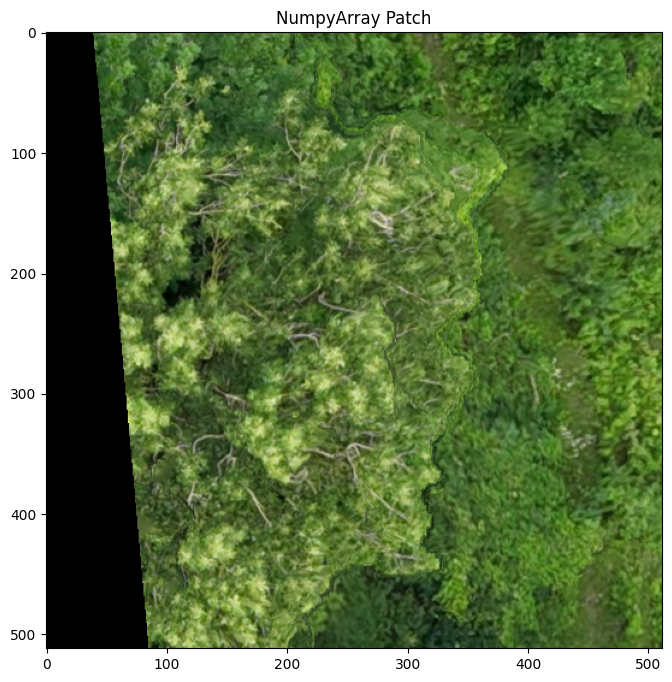

In [216]:
# plot the image data
##################################################
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(patch_image_data_npy.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("NumpyArray Patch")
plt.show()

3. Plot NumpyArray masks (if existent) 

In [ ]:
try: 
    # path to numpy mask
    mask_path_npy = output_raw_masks_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}_mask.npy"

    # load mask from this path
    # Mask data:
    ###########################################################
    mask_npy = np.load(mask_path_npy, allow_pickle=True) # load NumpyArray
    ###########################################################
    
    # Plot:
    ###########################################################
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # 2x2 grid (for 4 masks)
    axes = axes.flatten()  # easier to iterate through

    for i in range(mask_npy.shape[0]):  # iterate through the 9 classes
        axes[i].imshow(mask_npy[i], cmap="gray")
        axes[i].set_title(f"Class {i} - - {reversed_label_codes[i + 1]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

except:
    print("There aren't any labels in this patch!")



There aren't any labels in this patch!


4. Plot mask together with corresponding image data of the patch

In [ ]:
try:
    mask_path_npy = output_raw_masks_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}_mask.npy" # mask path
    mask_npy = np.load(mask_path_npy, allow_pickle=True) # load mask 
    
    print(mask_npy.shape)
    # create an empty mask with shape (512, 512, 3) > 3 for RGB representation
    combined_mask = np.zeros((mask_npy.shape[1], mask_npy.shape[2], 3), dtype=np.uint8) 

    # rgb-composition per class
    class_colors = [
        [255, 0, 0],    # class 1: red
        [0, 255, 0],    # class 2: green
        [0, 0, 255],    # class 3: blue
        [255, 255, 0],  # class 4: yellow
    ]

    for i in range(mask_npy.shape[0]):  # iterate through the 4 classes
        class_value = i + 1 # change index to class
        color_mask = np.zeros((mask_npy.shape[1], mask_npy.shape[2], 3), dtype=np.uint8)
        color_mask[mask_npy[i] == 1] = class_colors[i] 
        combined_mask += color_mask 

    fig, axes = plt.subplots(1, 2, figsize=(12, 12))  
   
    axes[0].imshow(combined_mask)
    axes[0].set_title(f"Labels")
    axes[0].axis("off")

    axes[1].imshow(patch_image_data_npy.transpose(1, 2, 0))  # transpose for RGB depiction
    axes[1].set_title("NumpyArray Patch")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

except:
    print("There aren't any labels in this patch!")
    


There aren't any labels in this patch!


In [219]:
try:

    if mask_npy is not None:
        # Create an empty image to hold the masked areas
        masked_image = np.zeros_like(patch_image_data_npy)  # Empty array with the same shape as the patch image

        # Create a 2x2 grid to display 4 masks
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # 2x2 grid for 4 masks
        axes = axes.flatten()  # Easier to iterate through

        for n in range(mask_npy.shape[0]):  # Iterate through all 4 classes
            # Create a mask for the current class
            class_mask = mask_npy[n] > 0  # Boolean mask (true or false) for the current class

            # Apply the mask to all RGB channels
            color_mask = np.zeros_like(patch_image_data_npy)
            for c in range(patch_image_data_npy.shape[0]):  # Apply mask per channel
                color_mask[c][class_mask] = patch_image_data_npy[c][class_mask]

            # Combine the masks for the output
            masked_image = np.maximum(masked_image, color_mask)  # Apply each mask to the image

            # Display the masked image for each class
            axes[n].imshow(color_mask.transpose(1, 2, 0))  # Transpose for RGB representation
            axes[n].set_title(f"Class {n + 1} - {reversed_label_codes[n + 1]}")
            axes[n].axis("off")

        # Optimize layout
        plt.tight_layout()
        plt.show()

    else:
        print("There aren't any labels in this patch!")

except Exception as e:
    print(f"An error occurred: {e}")


There aren't any labels in this patch!


In [180]:
mask_npy = None

5. Plot mask from the GeoTIFF

In [ ]:
# try: 
#     mask_path_gtif = output_raw_masks_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}_mask.tif" # mask path

#     # load test GeoTIFF patch data
#     with rasterio.open(mask_path_gtif) as src:

#         # GeoTIFF data
#         ###############################################################
#         mask_gtif = src.read()
        
#         # Plot:
#         ###########################################################
#         fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid (for 9 masks)
#         axes = axes.flatten()  # easier to iterate through

#         for i in range(mask_gtif.shape[0]):  # iterate through the 9 classes
#             axes[i].imshow(mask_gtif[i], cmap="gray")
#             axes[i].set_title(f"Class {i} - {reversed_label_codes[i + 1]}")
#             axes[i].axis("off")

#         plt.tight_layout()
#         plt.show()
# except:
#     print("There aren't any labels in this patch!")